In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import scipy.io
import scipy.sparse
import umap
import gc
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr, spearmanr

import anndata
import scanpy as sc
import scvi.model.base
import networkx as nx

from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import average_precision_score, f1_score
from scvedge.vedge_model import VEDGE

/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarn

In [ ]:
adata = anndata.read("../Data/vedge_corruption/adata_r50.h5ad.gz")
mvi = VEDGE.load("../model_trained/vedge_corruption/mvi_r50", adata)

/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File ../model_trained/vedge_corruption/mvi_r50/model.pt already downloaded                                


/home/Disk14T/xly/anaconda3/envs/xly/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [3]:
## get LSA-based smoothed estimates of accessibility
def get_knn_smoothing_estimate(latent_space, raw_space, K=50):
    nng = kneighbors_graph(latent_space, K)
    
    # for each row in the nng, take the corresponding neighbors and take the mean of each feature
    smoothed = []
    for idx in range(nng.shape[0]):
        #print(type(nng[idx]))
        coo = nng[idx].tocoo()
        smoothed.append(np.asarray(raw_space[coo.col].mean(0)).squeeze())
    return np.vstack(smoothed)

# ATAC imputation

In [4]:
adata_rna = adata[adata.obs.modality == 'expression']
adata_rna = adata_rna[adata_rna.obs.barcodes.argsort()].copy()
adata_atac = adata[adata.obs.modality == 'accessibility']
adata_atac = adata_atac[adata_atac.obs.barcodes.argsort()].copy()
adata_paired=adata[adata.obs.modality == 'paired']

In [5]:
atac_raw = (adata_atac.X[:, adata.var.modality.values == 'Peaks'] > 0).astype(int)
atac_imputed = mvi.get_accessibility_estimates(adata_rna)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [6]:
atac_lsa = (
    TruncatedSVD(n_components=30).fit_transform(
    TfidfTransformer().fit_transform(
        adata_atac.X[:, adata_atac.var.modality.values == 'Peaks']
    )))
atac_smooth = get_knn_smoothing_estimate(atac_lsa, atac_raw)

In [7]:
type(atac_raw)
#type(atac_imputed)
#type(atac_smooth)

scipy.sparse._csr.csr_matrix

In [7]:
atac_raw = np.asarray(atac_raw.todense()).flatten().squeeze()
#atac_raw = atac_raw.flatten().squeeze()
atac_imputed = atac_imputed.to_numpy().flatten()
atac_smooth = atac_smooth.flatten()

In [8]:
NSAMPLE = int(1e7)
samp_idx = np.random.choice(np.arange(atac_raw.shape[0]), NSAMPLE)
atac_raw = atac_raw[samp_idx]
atac_imputed = atac_imputed[samp_idx]
atac_smooth = atac_smooth[samp_idx]

In [ ]:
print("imputed vs. raw:", average_precision_score(atac_raw, atac_imputed))
#print("pred vs raw:",average_precision_score(atac_raw,atac_predict))
#print("smoothed vs. raw:", average_precision_score(atac_smooth, atac_imputed))
from scipy.stats import pearsonr
stat, pval = pearsonr(atac_raw, atac_imputed)
print(f"Pearson r = {stat:.4f}, p = {pval:.10e}")
r,p=pearsonr(atac_smooth, atac_imputed)
print(f"Pearson r = {r:.4f}, p = {p:.10e}")

imputed vs. raw: 0.3840774644587795
Pearson r = 0.4329, p = 0.00e+00
Pearson r = 0.8402, p = 0.00e+00


In [12]:
print(f"Pearson r = {stat:.4f}, p = {pval:.20e}")

print(f"Pearson r = {r:.4f}, p = {p:.20e}")

Pearson r = 0.4329, p = 0.00000000000000000000e+00
Pearson r = 0.8402, p = 0.00000000000000000000e+00


Text(0, 0.5, '')

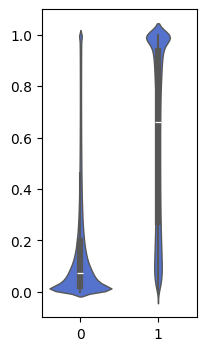

In [12]:
plt.figure(figsize=(2,4))
df_atac_imp = pd.DataFrame({
    'observed': atac_raw,
    'imputed': atac_imputed,
})
sns.violinplot(
    data = df_atac_imp,
    x = "observed",
    y = "imputed",
    color="royalblue",
    linewidth=1,
)
plt.xlabel("")
plt.ylabel("")
#plt.savefig(os.path.join(FIGPATH, "F4_atac_imp_boxplot.pdf"), dpi=600, bbox_inches='tight')

In [13]:
from sklearn.metrics import precision_recall_curve, auc
prec, recall, _ = precision_recall_curve(atac_raw, atac_imputed)
print(auc(recall, prec))

0.38418995384655075


<Figure size 400x400 with 0 Axes>

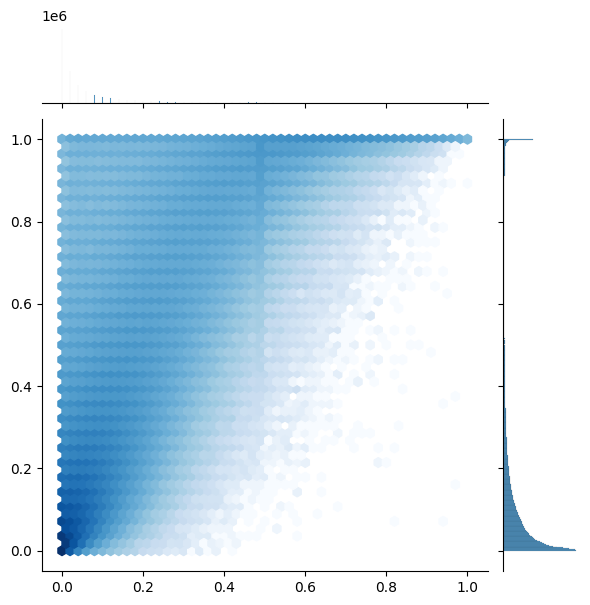

In [17]:
plt.figure(figsize=(4,4))
g = sns.jointplot(
    x=atac_smooth, 
    y=atac_imputed,
    cmap="Blues",
    kind='hex',
    joint_kws={'bins':'log'},
)
#plt.savefig(os.path.join(FIGPATH, "F4_atac_imp_smooth.pdf"), dpi=600, bbox_inches='tight')

In [18]:
spearmanr(atac_smooth, atac_imputed)

SignificanceResult(statistic=0.7740318270266866, pvalue=0.0)

## Uncertainty vs accuracy

In [19]:
STDSAMP = 5
stdiv_atac = np.stack([
    mvi.get_accessibility_estimates(adata_rna, use_z_mean=False) 
    for _ in range(STDSAMP)
], axis=2).std(axis=2).flatten()[samp_idx]

/tmp/ipykernel_1079647/3419524322.py:3: RuntimeWarning: divide by zero encountered in log
  x=np.log(stdiv_atac),


Text(0, 0.5, '')

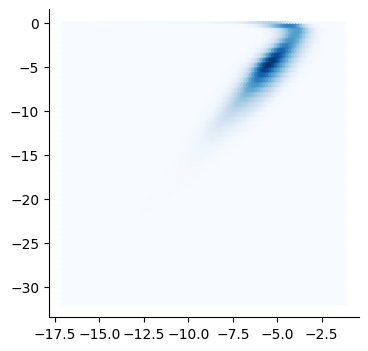

In [20]:
plt.figure(figsize=(4,4))
g = plt.hexbin(
    x=np.log(stdiv_atac), 
    y=np.log((atac_imputed - atac_raw) ** 2),
    cmap="Blues",
#     bins='log',
)

sns.despine(top=True, right=True, left=False, bottom=False)
plt.xlabel("")
plt.ylabel("")
#plt.savefig(os.path.join(FIGPATH, "F4_atac_stdvunc.pdf"), dpi=600, bbox_inches='tight')

In [21]:
interesting_idx = np.logical_and(np.log(stdiv_atac) < -6, np.log((atac_imputed - atac_raw) ** 2) > -2.5)

/tmp/ipykernel_1079647/176250202.py:1: RuntimeWarning: divide by zero encountered in log
  interesting_idx = np.logical_and(np.log(stdiv_atac) < -6, np.log((atac_imputed - atac_raw) ** 2) > -2.5)


In [22]:
interesting_idx.mean()

0.012309

Text(0, 0.5, '')

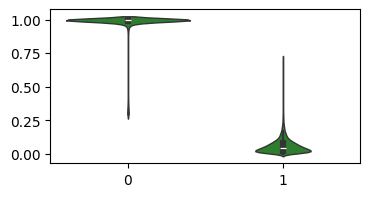

In [23]:
plt.figure(figsize=(4,2))
df_atac_imp = pd.DataFrame({
    'observed': atac_raw,
    'imputed': atac_imputed,
})
sns.violinplot(
    data = df_atac_imp.loc[interesting_idx],
    x="observed",
    y="imputed",
    color="forestgreen",
    linewidth=1,
)
plt.xlabel("")
plt.ylabel("")
#plt.savefig(os.path.join(FIGPATH, "F4_imp_select_boxplot.pdf"), dpi=600, bbox_inches='tight')

Text(0, 0.5, '')

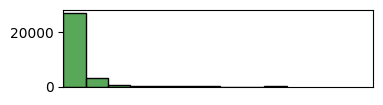

In [24]:
# observed as 1 but *confidently* imputed 0
plt.figure(figsize=(4,1))
g=sns.histplot(
    atac_smooth[np.logical_and(atac_raw.astype(bool), interesting_idx)],
    bins=10,
    color="forestgreen",
)
g.set(xlim=(0, 1))
g.set_xticks([])
plt.ylabel("")
#plt.savefig(os.path.join(FIGPATH, "F4_hist_0.pdf"), dpi=600, bbox_inches='tight')

Text(0, 0.5, '')

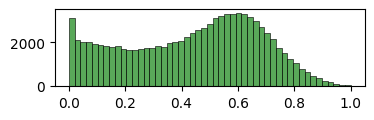

In [25]:
# observed as 0 but *confidently* imputed as 1
plt.figure(figsize=(4,1))
sns.histplot(
    atac_smooth[np.logical_and((1-atac_raw).astype(bool), interesting_idx)], 
    bins=49,
    color="forestgreen",
)
plt.ylabel("")
#plt.savefig(os.path.join(FIGPATH, "F4_hist_1.pdf"), dpi=600, bbox_inches='tight')

# RNA imputation

In [6]:
rna_raw = adata_rna.X[:, adata.var.modality.values == 'Gene Expression'].copy()
rna_norm = rna_norm = rna_raw / rna_raw.sum(1)
rna_imputed = mvi.get_normalized_expression(adata_atac)
rna_pca = TruncatedSVD(n_components=30).fit_transform(rna_norm)
rna_norm=rna_norm.tocsr()
rna_smooth = get_knn_smoothing_estimate(rna_pca, rna_norm)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


In [7]:
samp_idx_rna = np.random.choice(np.arange(rna_raw.shape[0]), NSAMPLE)
rna_raw = np.asarray(rna_raw.todense()).flatten().squeeze()[samp_idx_rna]
#rna_raw=rna_raw.flatten().squeeze()[samp_idx_rna]
rna_norm = np.asarray(rna_norm.todense().flatten()).squeeze()[samp_idx_rna]
rna_imputed = rna_imputed.to_numpy().flatten()[samp_idx_rna]
rna_smooth = rna_smooth.flatten()[samp_idx_rna]

NameError: name 'NSAMPLE' is not defined

In [29]:
print(spearmanr(rna_norm, rna_imputed))
print(spearmanr(rna_smooth, rna_imputed))

SignificanceResult(statistic=0.38553154494443975, pvalue=0.0)
SignificanceResult(statistic=0.7858681316694637, pvalue=0.0)


Text(0, 0.5, '')

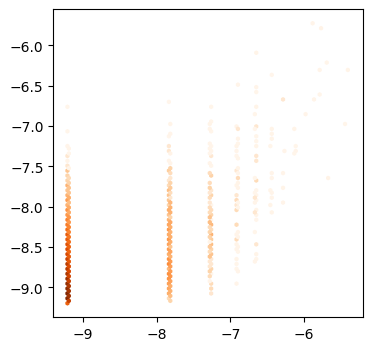

In [30]:
plt.figure(figsize=(4,4))
g = plt.hexbin(
    x=np.log(rna_norm + 1e-4), 
    y=np.log(rna_imputed + 1e-4), 
    cmap="Oranges",
    bins='log',
)
plt.xlabel("")
plt.ylabel("")
#plt.savefig(os.path.join(FIGPATH, "F4_rna_imp_obs.pdf"), dpi=600, bbox_inches='tight')

Text(0, 0.5, '')

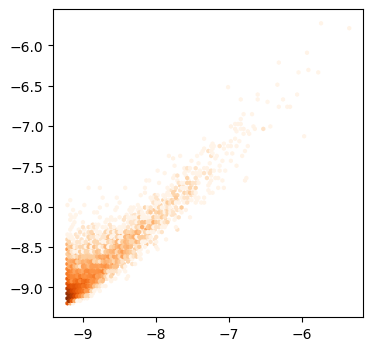

In [31]:
plt.figure(figsize=(4,4))
g = plt.hexbin(
    x=np.log(rna_smooth + 1e-4), 
    y=np.log(rna_imputed + 1e-4), 
    cmap="Oranges",
    bins='log',
)
plt.xlabel("")
plt.ylabel("")
#plt.savefig(os.path.join(FIGPATH, "F4_rna_imp_smooth.pdf"), dpi=600, bbox_inches='tight')

## rna simulation

In [32]:
rna_raw = adata_rna.X[:, adata.var.modality.values == 'Gene Expression'].copy()
rna_norm = rna_norm = rna_raw / rna_raw.sum(1)
rna_simulated = mvi.get_normalized_expression(adata_rna)
rna_pca = TruncatedSVD(n_components=30).fit_transform(rna_norm)
rna_norm=rna_norm.tocsr()
rna_smooth = get_knn_smoothing_estimate(rna_pca, rna_norm)

In [36]:
NSAMPLE = int(1e7)
samp_idx_rna = np.random.choice(np.arange(rna_raw.shape[0]), NSAMPLE)
#rna_raw = np.asarray(rna_raw.todense()).flatten().squeeze()[samp_idx_rna]
rna_raw=rna_raw.flatten().squeeze()[samp_idx_rna]
rna_norm = np.asarray(rna_norm.todense().flatten()).squeeze()[samp_idx_rna]
#rna_norm = np.asarray(rna_norm.flatten()).squeeze()[samp_idx_rna]
rna_simulated = rna_simulated.to_numpy().flatten()[samp_idx_rna]
rna_smooth = rna_smooth.flatten()[samp_idx_rna]

In [37]:
print(spearmanr(rna_norm, rna_simulated))
print(spearmanr(rna_smooth, rna_simulated))

SignificanceResult(statistic=0.3793223969029347, pvalue=0.0)
SignificanceResult(statistic=0.7855921345621014, pvalue=0.0)


Text(0, 0.5, '')

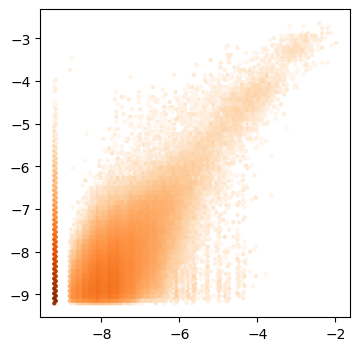

In [38]:
plt.figure(figsize=(4,4))
g = plt.hexbin(
    x=np.log(rna_norm + 1e-4), 
    y=np.log(rna_simulated + 1e-4), 
    cmap="Oranges",
    bins='log',
)
plt.xlabel("")
plt.ylabel("")
#plt.savefig(os.path.join(FIGPATH, "F4_rna_sim_obs.pdf"), dpi=600, bbox_inches='tight')

Text(0, 0.5, '')

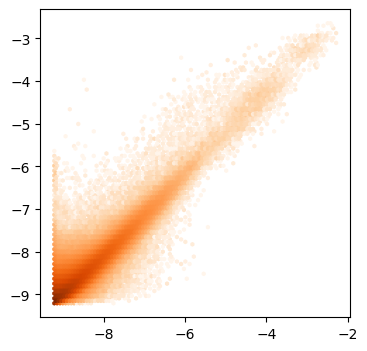

In [39]:
plt.figure(figsize=(4,4))
g = plt.hexbin(
    x=np.log(rna_smooth + 1e-4), 
    y=np.log(rna_simulated + 1e-4), 
    cmap="Oranges",
    bins='log',
)
plt.xlabel("")
plt.ylabel("")
#plt.savefig(os.path.join(FIGPATH, "F4_rna_sim_smooth.pdf"), dpi=600, bbox_inches='tight')

## atac simulation

In [40]:
atac_raw = (adata_atac.X[:, adata.var.modality.values == 'Peaks'] > 0).astype(int)
atac_sim = mvi.get_accessibility_estimates(adata_atac)

In [41]:
atac_lsa = (
    TruncatedSVD(n_components=30).fit_transform(
    TfidfTransformer().fit_transform(
        adata_atac.X[:, adata_atac.var.modality.values == 'Peaks']
    )))
atac_smooth = get_knn_smoothing_estimate(atac_lsa, atac_raw)

In [42]:
atac_raw = np.asarray(atac_raw.todense()).flatten().squeeze()
#atac_raw = atac_raw.flatten().squeeze()
atac_sim = atac_sim.to_numpy().flatten()
atac_smooth = atac_smooth.flatten()

In [43]:
NSAMPLE = int(1e7)
samp_idx = np.random.choice(np.arange(atac_raw.shape[0]), NSAMPLE)
atac_raw = atac_raw[samp_idx]
atac_sim = atac_sim[samp_idx]
atac_smooth = atac_smooth[samp_idx]

In [44]:
print("imputed vs. raw:", average_precision_score(atac_raw, atac_sim))
#print("smoothed vs. raw:", average_precision_score(atac_smooth, atac_imputed))

imputed vs. raw: 0.41357124055082056


Text(0, 0.5, '')

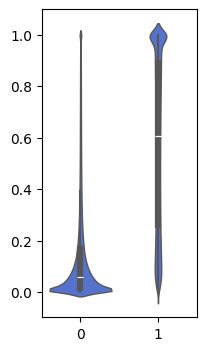

In [45]:
plt.figure(figsize=(2,4))
df_atac_imp = pd.DataFrame({
    'observed': atac_raw,
    'imputed': atac_sim,
})
sns.violinplot(
    data = df_atac_imp,
    x = "observed",
    y = "imputed",
    color="royalblue",
    linewidth=1,
)
plt.xlabel("")
plt.ylabel("")
#plt.savefig(os.path.join(FIGPATH, "F4_atac_sim_boxplot.pdf"), dpi=600, bbox_inches='tight')

In [46]:
spearmanr(atac_smooth, atac_sim)

SignificanceResult(statistic=0.8236087483241581, pvalue=0.0)

## specific examples

In [15]:
adata.obsm["X_MultiVI"] = mvi.get_latent_representation(adata)

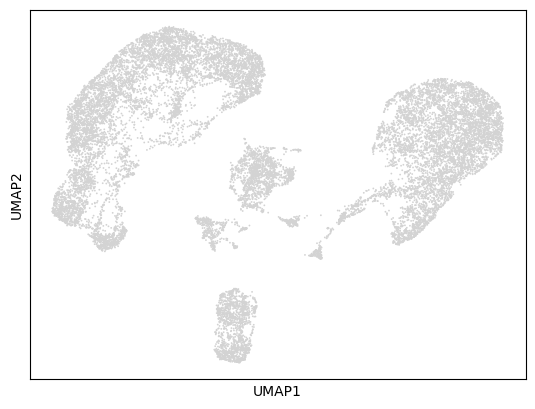

In [15]:
sc.pl.umap(adata)

In [16]:
ex_rna_imp = mvi.get_normalized_expression()

In [17]:
def single_plot(c, is_binary=False):
    c=np.array(c)

    if is_binary:
        plt.figure(figsize=(2,2))
    else:
        plt.figure(figsize=(3,2))
    g = sns.scatterplot(
        x=adata.obsm["X_umap"][:,0],
        y=adata.obsm["X_umap"][:,1],
        #s=(c*3+1) if is_binary else 1,
        s=1,
        hue=c,
        palette="tab10" if is_binary else "viridis",
    )
    sns.despine(bottom=True, top=True, left=True, right=True)
    g.set_xticks([])
    g.set_yticks([])

In [8]:
def single_plot(c, is_binary=False):
    c = np.array(c)

    #if is_binary:
    #    plt.figure(figsize=(2, 2))
    #else:
    plt.figure(figsize=(3, 2))
    
    if not is_binary:
    # 用 scatter 返回的对象作为 mappable
        scatter = plt.scatter(
        adata.obsm["X_umap"][:, 0],
        adata.obsm["X_umap"][:, 1],
        c=c,
        cmap="tab10" if is_binary else "viridis",
        s=3,
        linewidths=0,
    )

        plt.xticks([])
        plt.yticks([])
        sns.despine(bottom=True, top=True, left=True, right=True)

        plt.colorbar(scatter, fraction=0.04, pad=0.02)

    if is_binary:
        g = sns.scatterplot(
        x=adata.obsm["X_umap"][:,0],
        y=adata.obsm["X_umap"][:,1],
        #s=(c*3+1) if is_binary else 1,
        s=1,
        hue=c,
        palette="tab10" if is_binary else "viridis",
    )
        sns.despine(bottom=True, top=True, left=True, right=True)
        g.set_xticks([])
        g.set_yticks([])

        handles, labels = g.get_legend_handles_labels()

# 去掉旧 legend
        g.legend_.remove()

# 创建新的 legend，并放大点大小
        new_legend = g.legend(
    handles=handles,
    labels=labels,
    loc='lower right',
    bbox_to_anchor=(1.0, 0.0),
    frameon=False,
    title=None,
    scatterpoints=1,
    markerscale=2.5  # 放大点大小，默认是 1.0
)


In [17]:
def plot_gene(gn):
    gene_idx = np.where(adata.var.name == gn.strip())[0][0]
    raw_counts = np.asarray(adata.X[:,gene_idx].todense()).squeeze()
    single_plot(np.log((raw_counts / raw_counts.sum()) + 1e-5))
    #plt.savefig(os.path.join(FIGPATH, "F4_umap_rna_raw.pdf"), dpi=600, bbox_inches='tight')

    plt.figure()
    single_plot(np.log(ex_rna_imp.iloc[:,gene_idx]))
    #plt.savefig(os.path.join(FIGPATH, "F4_umap_rna_imp.pdf"), dpi=600, bbox_inches='tight')
    
    entry = adata.var.iloc[gene_idx]
    promoter = adata.var.loc[
        (adata.var.chr==entry.chr) & 
        (adata.var.start < entry.start) & 
        (adata.var.end > entry.end) &
        (adata.var.modality == 'Peaks')
    ]
    if promoter.shape[0] != 1:
        print('no promoter')
        return
    print(promoter['name'].values[0])
    peak_loc = np.where(adata.var[adata.var.modality=='Peaks'].name == promoter['name'].values[0])[0][0]
    print(peak_loc)
    acc_all = mvi.get_accessibility_estimates(adata)
    ex_atac_imp = acc_all.iloc[:, peak_loc].values
    raw_acc = (np.asarray(adata.X[:,peak_loc].todense()).squeeze() > 0).astype(int)
    print(ex_atac_imp.shape,raw_acc.shape)

    
    plt.figure()
    single_plot(raw_acc, True)
    #plt.savefig(os.path.join(FIGPATH, "F4_umap_atac_raw.pdf"), dpi=600, bbox_inches='tight')

    plt.figure()
    single_plot(ex_atac_imp)
    #plt.savefig(os.path.join(FIGPATH, "F4_umap_atac_imp.pdf"), dpi=600, bbox_inches='tight')

chr12:6789036-6789926
16860
(18018,) (18018,)


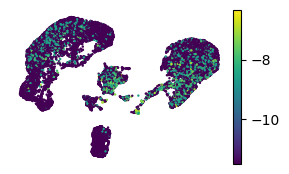

<Figure size 640x480 with 0 Axes>

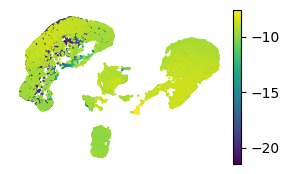

<Figure size 640x480 with 0 Axes>

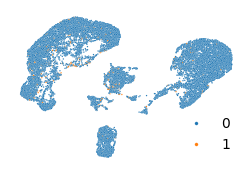

<Figure size 640x480 with 0 Axes>

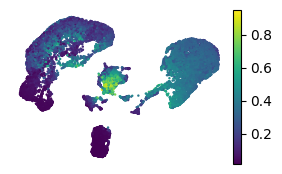

In [25]:
plot_gene('CD4')

chr11:118343910-118344797
15874
(18018,) (18018,)


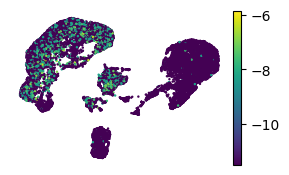

<Figure size 640x480 with 0 Axes>

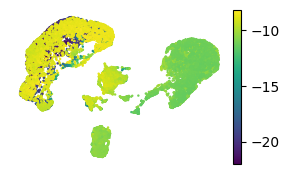

<Figure size 640x480 with 0 Axes>

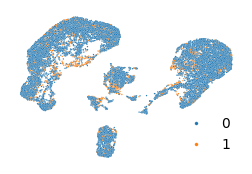

<Figure size 640x480 with 0 Axes>

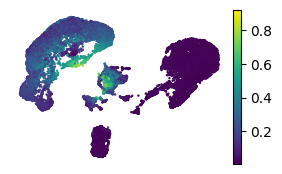

In [26]:
plot_gene('CD3G')
#print('MS4A1' in adata.var.name.unique())

chr19:51372468-51373378
41593
(18018,) (18018,)


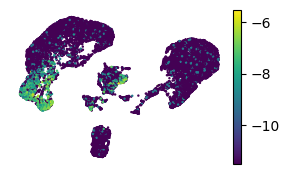

<Figure size 640x480 with 0 Axes>

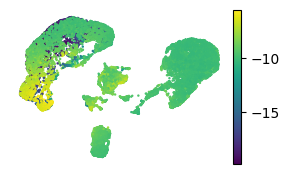

<Figure size 640x480 with 0 Axes>

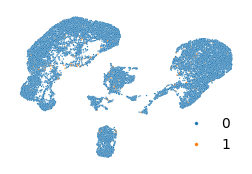

<Figure size 640x480 with 0 Axes>

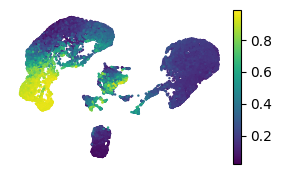

In [28]:
#plot_gene('CD8A')
plot_gene('NKG7')
#print('NKG7' in adata.var.name.unique())

chr12:69347961-69348804
19019
(18018,) (18018,)


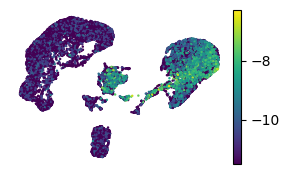

<Figure size 640x480 with 0 Axes>

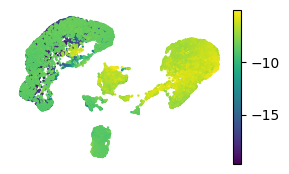

<Figure size 640x480 with 0 Axes>

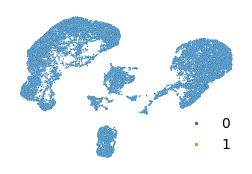

<Figure size 640x480 with 0 Axes>

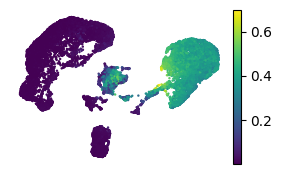

In [30]:
plot_gene('LYZ')